# Introduction

In this notebook, I want to draw mazes (preferably procedurally generated), then build entities that try to solve the maze. Bonus points if it can be done visually with an animation.

## Design Choices

### Where does the maze live?

To generate mazes, we gotta make a few decisions. First, we need to think about where the maze lives - should it live on a grid? A circle? Something else?

### How do we represent the maze?

Secondly, we need to think about how represent the maze. Do we need to consider a long hallway? What about just a fully connected graph? Something else?

# Randomized depth-first search

This is a randomized version of the depth-first search algorithm, and is typically implemented with a stack datastructure.

* Representation: (M by N) grid
  * Each cell is a point on the maze grid
  * Each cell starts with four walls.

## Algorithm in words

* Start from random cell
* Select random neighbor that has not been visited
* Remove the wall between the two cells, marking new cell as visited.
  * Add new cell to stack of visited cells
* Repeat process until reaching a dead end
  * A dead end is a cell with no unvisited neighbors

* When at a dead end, back-track through visited cells until reaching an unvisited neighbor, continuing the path generation process until every cell is visited.
* When we back track to the first cell, we know the process is finished.

In [1]:
!pip install bidict

In [2]:
from bidict import bidict

In [232]:
import numpy as np
from bidict import bidict
import random

class Maze(object):
  def __init__(self, M, N):
    """
    Initialize the maze as a rectangular M by N grid.
    """
    self.M = M
    self.N = N
    self._visited = {(i, j): False for i in range(M) for j in range(N)}
    self._path = bidict()
    
    # Each key maps to a list of neighbors.
    self._connected_neighbors = {(i, j): set() for i in range(M) for j in range(N)}
  
  def get_neighbors_list(self, cell):
    """
    Get a list of all valid neighbors to cell
    """
    neighbors = []
    neighbors_list = [
      (cell[0], cell[1] - 1),
      (cell[0], cell[1] + 1),
      (cell[0] + 1, cell[1]),
      (cell[0] - 1, cell[1])
    ]
    
    for neighbor in neighbors_list:
      if neighbor in self._visited: # Check if (i, j) is a valid index.
        neighbors.append(neighbor)
    return neighbors
       
  
  def are_neighbors_visited(self, cell):
    """
    Given a cell in the grid, return true if any its neighbors have been
    visited. An edge or corner cell has fewer neighbors.
    
    Args:
      cell - a Tuple(int, int) representing a cell in the grid.
    
    Returns:
      True if neighbors are visited, otherwise false.
    """
    # Its okay if we generate out of range neighbors, the keys of our "_visited"
    # dictionary are 
    
    for neighbor in self.get_neighbors_list(cell):
      if self._visited[neighbor]:
        return True
    return False
  
    
  def select_random_cell(self):
    """
    Returns a tuple representing a cell in the maze.
    """
    return (
      np.random.randint(low=0, high=self.M-1), 
      np.random.randint(low=0, high=self.N-1)
    )
  
  
  def get_unvisited_neighbors(self, cell):
    """
    Returns a random adjacent cell
    """
    unvisited = []
    for neighbor in self.get_neighbors_list(cell):
      if self._visited[neighbor] == False:
        unvisited.append(neighbor)
    return unvisited
  
  
  def generate_randomized_dfs(self):
    """
    Generate a maze using randomized depth first search
    """
    first_cell = self.select_random_cell()
    stack = [first_cell]
    self._visited[first_cell] = True
    
    while len(stack) != 0:
      current_cell = stack.pop()
      neighbors = self.get_unvisited_neighbors(current_cell)
      
      if len(neighbors) > 0:
        stack.append(current_cell)
        next_cell = random.choice(neighbors)
        self._visited[next_cell] = True
        stack.append(next_cell)
        
        # This is effectively an adjacency list for a bi-directional graph:
        self._connected_neighbors[current_cell].add(next_cell)
        self._connected_neighbors[next_cell].add(current_cell)
        if (current_cell, next_cell) not in self._path or (current_cell, next_cell) not in self._path.inverse:
          self._path[(current_cell, next_cell)] = (next_cell, current_cell)
#         print(current_cell, "->", next_cell)
        

In [233]:
m = Maze(50, 50)

In [234]:
print(m.get_neighbors_list(cell=(2,2)))
print(m.get_neighbors_list(cell=(0,0)))

[(2, 1), (2, 3), (3, 2), (1, 2)]
[(0, 1), (1, 0)]


In [235]:
m.generate_randomized_dfs()

In [236]:
import matplotlib.pyplot as plt

## Visualize as a graph

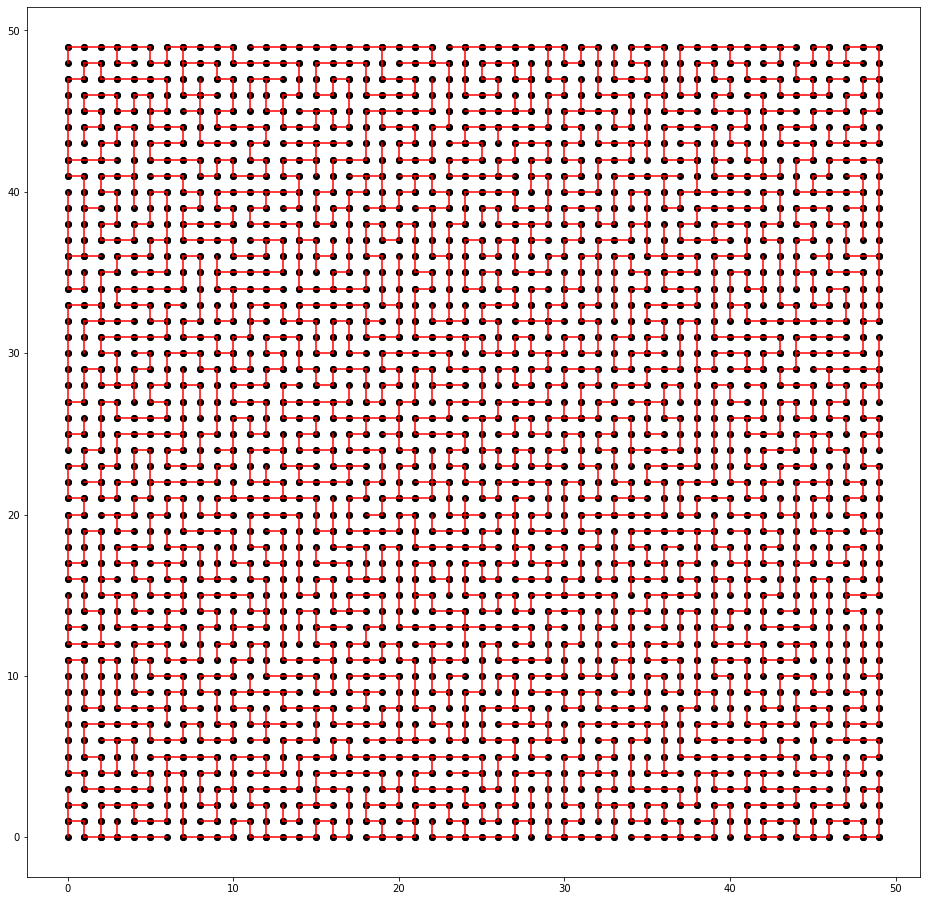

In [237]:
fig, ax = plt.subplots(figsize=(16, 16))
for path in m._path:
  ((x1, y1), (x2, y2)) = path
  x_values = [x1, x2]
  y_values = [y1, y2]
  ax.plot(x_values, y_values, color='red')
  ax.scatter(x_values, y_values, color='black')

## Visualize more traditionally

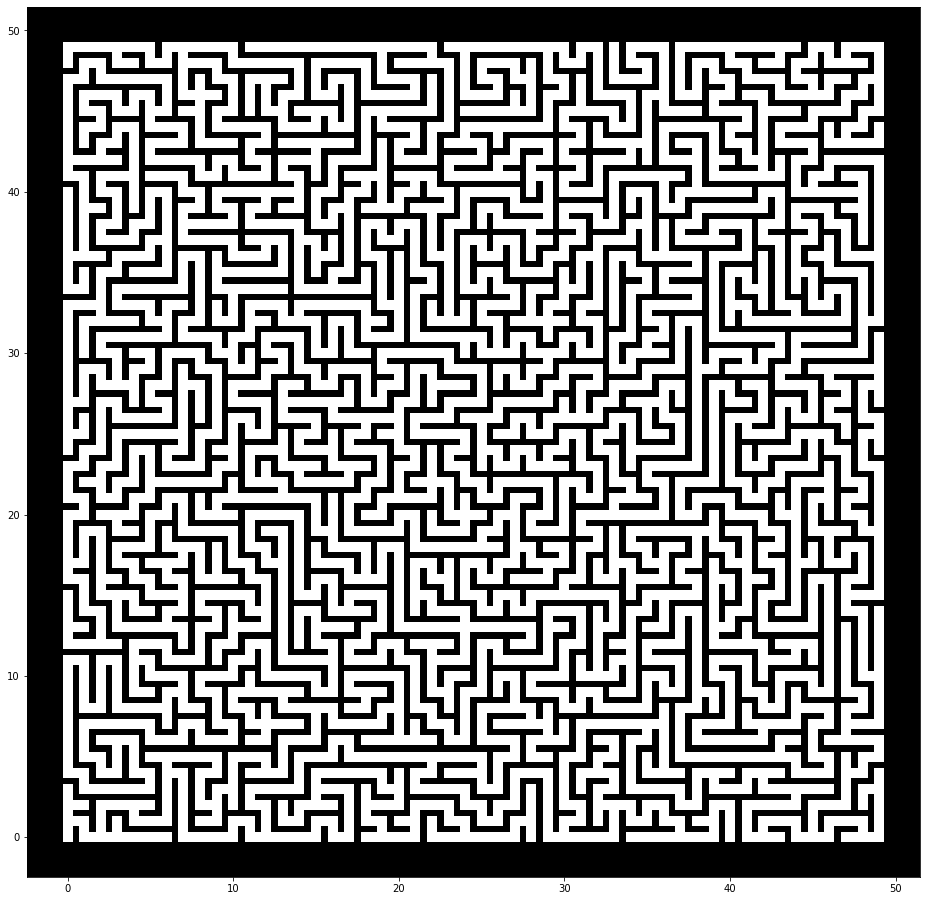

In [238]:
fig, ax = plt.subplots(figsize=(16, 16))
for path in m._path:
  ((x1, y1), (x2, y2)) = path
  x_values = [x1, x2]
  y_values = [y1, y2]
  ax.set_facecolor('black')
  ax.plot(x_values, y_values, linewidth=10, color='white')


In [252]:
from collections import defaultdict 
import pandas as pd

13.7 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


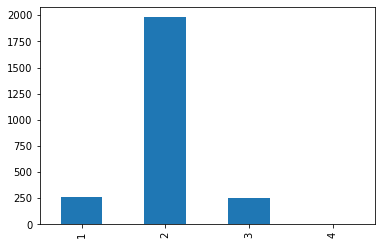

In [256]:
%%timeit
# First way
barplot = defaultdict(lambda:0)
for neighbors in m._connected_neighbors.values():
  barplot[len(neighbors)] += 1
pd.Series(barplot).sort_index().plot.bar()

14.5 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


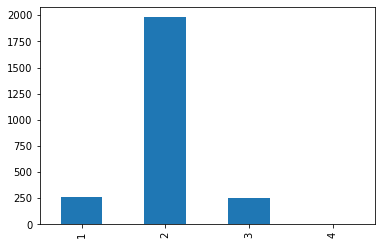

In [255]:
%%timeit
# Another Way
pd.Series([len(neighbors) for neighbors in m._connected_neighbors.values()]).value_counts().sort_index().plot.bar()